# Imports

In [1]:
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io import wavfile

from sklearn.metrics import accuracy_score, hamming_loss, zero_one_loss, auc

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import random

import librosa
import pickle as pk

from keras.layers import Conv2D, MaxPool2D, Activation, Dense, Input, Flatten, BatchNormalization, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from keras.utils import Sequence
import keras.backend as K
import tensorflow as tf

/home/emanuele.dallalonga/miniconda3/envs/musictagger/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###### Parameters

In [27]:
#Hardware Parameters
n_gpus = 4

#Mel parameters
sr = 22050
n_sample_fft = 2048 
hop_length = 512

#Training Parameters
batch_size = 32
max_epochs = 200
max_trainings = 5
kernel_initializer = 'glorot_uniform'#'he_uniform'

if batch_size % n_gpus != 0:
    print("Batch size should be dividibile per n_gpus")

# SGD parameters
starting_learning_rate = 0.01
momentum = 0.9
global_decay = 0.2
local_decay = 1e-6

# EarlyStopping Parameters
min_improvement = 0
patience = 5

# Paths
dataset_dir = '../data/MagnaTagATune/MEL_default_hop/'
annotations_path = '../data/MagnaTagATune/annotation_reduced_50.csv'

checkpoint_dir = './checkpoints_MEL_32f/'
checkpoint_file_name = 'weights-{epoch:03d}-{val_loss:.5f}.hdf5'
log_dir ='./logs_MEL_32f/'

# Functions

###### Align dataset split to batch size

In [28]:
def align_split(split, batch_size, num_songs):
    num_songs_split = split*num_songs
    return int(num_songs_split - num_songs_split%batch_size)/num_songs

###### Data reading during training

In [29]:
class MagnaTagATuneSequence(Sequence):

    def __init__(self, train_set_paths, train_set_labels, batch_size):
        self.paths, self.y = train_set_paths, train_set_labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x_paths = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        for value in batch_x_paths:
            path = dataset_dir + value[:-3]+'p'
            S = pk.load(open(path,'rb'))
            batch_x.append(S)
        batch_x = np.array(batch_x)[:,:,:,np.newaxis]        
        return (batch_x,batch_y)    

###### Performance Metrics (not used anymore)

In [50]:
def ratio_wrong_over_correct_ones(y_true, y_pred):
    op1 = K.sum(K.abs(K.cast(y_true - K.round(y_pred), dtype='float32')))
    op2 = K.sum(K.cast(K.equal(y_true,1.0),dtype='float32'))
    return op1/op2

def ratio_correct_ones(y_true, y_pred):
    op1 = K.sum(K.cast(K.equal(y_true + K.round(y_pred+0.15),2.0),dtype='float32'))
    op2 = K.sum(K.cast(K.equal(y_true,1.0),dtype='float32'))
    return op1/op2

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred, summation_method='careful_interpolation')

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value


###### Best checkpoint selection

In [31]:
def find_best_checkpoint(prev_chkpts):
    best_ratio = np.inf
    best_chkpt = ''
    best_epoch = 0
    for chkpt in prev_chkpts:
        epoch = int(chkpt[8:11])
        ratio = float(chkpt[12:19])
        
        if ratio < best_ratio:
            best_ratio = ratio
            best_chkpt = chkpt
            best_epoch = epoch
    print('\n starting from model {} \n'.format(best_chkpt))
    return best_chkpt, best_epoch

# Preparation

###### Prepare Dataset

In [32]:
annotations = pd.read_csv(annotations_path, sep='\t')

tot_t_size = 0.866203
tot_train_set, test_set = train_test_split(annotations, train_size=tot_t_size, test_size=(1-tot_t_size), random_state=42) 

print("Complete Train set size: {}".format(tot_train_set.shape[0]))
print("Test set size: {} \n".format(test_set.shape[0]))

t_size = 0.91429
train_set, val_set = train_test_split(tot_train_set, train_size=t_size, test_size=(1-t_size), random_state=42) 

print("Train set size: {}".format(train_set.shape[0]))
print("Validation set size: {} \n".format(val_set.shape[0]))

train_set_paths = train_set['mp3_path'].values
train_set_labels = train_set.drop(columns=['mp3_path','Unnamed: 0']).values

y_dimension = train_set_labels.shape[1]
S = pk.load(open(dataset_dir + annotations['mp3_path'][0][:-3]+ 'p','rb'))
x_dimension = S.shape

print("X dimension: {}\nY dimension: {} \n".format(x_dimension, y_dimension))

   
val_set_paths = val_set['mp3_path'].values
val_set_labels = val_set.drop(columns=['mp3_path','Unnamed: 0']).values
    

    
print('\n* * * Loading Validation Set into Memory * * *\n')

val_set_data = []
for value in tqdm(val_set_paths):
    path = dataset_dir+value[:-3]+'p'
    S = pk.load(open(path,'rb'))
    val_set_data.append(S)  
val_set_data = np.array(val_set_data)[:,:,:,np.newaxis] 

  6%|▋         | 122/1920 [00:00<00:01, 1212.80it/s]

Complete Train set size: 22400
Test set size: 3460 

Train set size: 20480
Validation set size: 1920 

X dimension: (128, 911)
Y dimension: 50 


* * * Loading Validation Set into Memory * * *



100%|██████████| 1920/1920 [00:01<00:00, 1013.61it/s]


In [33]:
#pick up random song in training
#np.random.seed(0)
random_song = np.random.randint(0,train_set.shape[0],)
song_path = train_set.iloc[random_song]['mp3_path']
print('Tot train set shape(df): {}'.format(train_set.shape))
print('Tot train set paths: {}'.format(train_set_paths.shape))
print('Song from train set (df): {}'.format(train_set.iloc[random_song]['mp3_path']))
print('Song from train set paths: {}'.format(train_set_paths[random_song]))

labels_from_annotation = annotations.loc[annotations['mp3_path'] == song_path]
print(labels_from_annotation.values[0][1:-1])

print(train_set_labels[random_song])

Tot train set shape(df): (20480, 52)
Tot train set paths: (20480,)
Song from train set (df): 4/tilopa-kyotaku_live-07-ajikan-233-262.mp3
Song from train set paths: 4/tilopa-kyotaku_live-07-ajikan-233-262.mp3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


###### Modify session

In [34]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
keras.backend.set_session(session)

######  Building Model

In [ ]:
n_filters = 64

model = keras.Sequential()

model.add(Conv2D(filters=n_filters, kernel_size=(3,3),padding='valid',data_format='channels_last', input_shape=(x_dimension[0],x_dimension[1],1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=n_filters*2, kernel_size=(3,3),padding='valid',data_format='channels_last', input_shape=(x_dimension[0],x_dimension[1],1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=n_filters*2, kernel_size=(3,3),padding='valid',data_format='channels_last', input_shape=(x_dimension[0],x_dimension[1],1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=n_filters*2, kernel_size=(3,3),padding='valid',data_format='channels_last', input_shape=(x_dimension[0],x_dimension[1],1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(units=y_dimension, activation='sigmoid'))

In [ ]:
model.summary()

###### Callbacks definition

In [ ]:
class MyCallBack(keras.callbacks.Callback):
    def __init__(self, callbacks, model, is_tb=False):
            super().__init__()
            self.callback = callbacks
            self.is_tb = is_tb
            if not self.is_tb:
                self.model = model
                self.model_original = model

    def on_epoch_begin(self,epoch,logs=None):
            if not self.is_tb:
                self.model = self.model_original
            self.callback.on_epoch_begin(epoch, logs=logs)

    def on_epoch_end(self,epoch,logs=None):
            if not self.is_tb:
                self.model = self.model_original
            else:
                y_pred = self.model.predict(self.validation_data[0])
                auc_skl = roc_auc_score(self.validation_data[1], y_pred)
                print('\nSKLearn validation auc: {}'.format(auc_skl))
            self.callback.on_epoch_end(epoch, logs=logs)

    def on_batch_end(self, batch, logs=None):
            if not self.is_tb:
                self.model = self.model_original
            self.callback.on_batch_end(batch, logs=logs)

    def on_batch_begin(self, batch, logs=None):
            if not self.is_tb:
                self.model = self.model_original
            self.callback.on_batch_begin(batch, logs=logs)
            
    def on_train_begin(self, logs=None):
            if not self.is_tb:
                self.model = self.model_original
            self.callback.set_model(self.model)
            self.callback.on_train_begin(logs=logs)


cbk_tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, write_graph=True,
                                         write_grads=False, write_images=False, embeddings_freq=0,
                                         embeddings_layer_names=None, embeddings_metadata=None)

cbk_es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                          min_delta=min_improvement, patience=patience, verbose=1)

cbk_mc = keras.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                            filepath=checkpoint_dir+checkpoint_file_name, 
                                            verbose=1)

cbk = MyCallBack(cbk_tb, model, is_tb=True)
cbk2 = MyCallBack(cbk_mc, model)

callbacks = [cbk,cbk_es,cbk2]

### Training

In [ ]:
initial_epoch = 0
training_nr = 0

parallel_model = keras.utils.multi_gpu_model(model, gpus=n_gpus)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

while (initial_epoch <= max_epochs) and (training_nr <= max_trainings):
    
    best_checkpoint = ''
    best_epoch = 0
    
    previous_checkpoints = os.listdir(checkpoint_dir)
    
    if previous_checkpoints != []:
        best_checkpoint, best_epoch = find_best_checkpoint(previous_checkpoints)
        initial_epoch = best_epoch             
    
    print('\n\n* * * * Starting training {0} from epoch {1} * * * * \n\n'.format(training_nr,  initial_epoch+1))
    
    #update lr
    decay = global_decay ** training_nr
    learning_rate = starting_learning_rate * decay
    
    
    training_nr = training_nr + 1
    
    optimizer = SGD(lr=learning_rate, momentum=momentum, decay=local_decay , nesterov=True)
    
    if len(previous_checkpoints)!=0:
        model.load_weights(checkpoint_dir + best_checkpoint)
        parallel_model = keras.utils.multi_gpu_model(model, gpus=n_gpus)
    
    
    parallel_model.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    parallel_model.fit_generator(MagnaTagATuneSequence(train_set_paths, train_set_labels, batch_size),
                                 validation_data = (val_set_data, val_set_labels),
                                 epochs=max_epochs, callbacks = callbacks, initial_epoch = initial_epoch)

###### Prepare Test Set

In [35]:
test_set_paths = test_set['mp3_path'].values
test_set_labels = test_set.drop(columns=['mp3_path','Unnamed: 0']).values
test_set_size = len(test_set_paths)
print("Test set size: {} ".format(test_set_size))

Test set size: 3460 


###### Load best Model

In [36]:
previous_checkpoints = os.listdir(checkpoint_dir)
best_checkpoint, best_epoch = find_best_checkpoint(previous_checkpoints)
#model.load_weights(checkpoint_dir + best_checkpoint)
model = keras.models.load_model(checkpoint_dir + best_checkpoint)
parallel_model = keras.utils.multi_gpu_model(model, gpus=n_gpus)


 starting from model weights-028-0.13129.hdf5 



/home/emanuele.dallalonga/miniconda3/envs/musictagger/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


###### Prediction and evaluation

In [37]:
predictions = parallel_model.predict_generator(MagnaTagATuneSequence(test_set_paths, test_set_labels, batch_size), verbose=1)
#predictions = parallel_model.predict(test_set_data,batch_size=batch_size,verbose=1)

109/109 [==============================] - 13s 115ms/step


In [38]:
try:
    roc_auc = roc_auc_score(test_set_labels, predictions)
    print("Test roc auc result: {} ".format(roc_auc))
except Error as e:
    print(e)

Test roc auc result: 0.8932105996027028 


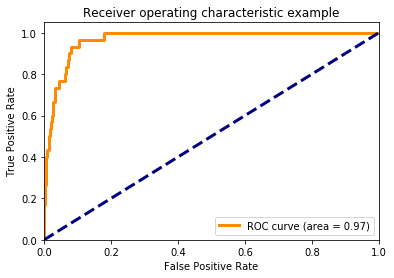

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(test_set_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(test_set_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
fpr["micro"], tpr["micro"], _ = roc_curve(test_set_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



plt.figure()
lw = 3
label = 2
plt.plot(fpr[label], tpr[label], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[label])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [40]:
test = predictions[0]
print("All the same: {}".format(all([all(i) for i in [test-i<np.finfo(np.float32).eps for i in predictions]])))

All the same: False


In [51]:
a=501
print(predictions[a])
print(test_set_labels[a])

d = dict()
for idx in range(y_dimension):
    
K.eval(ratio_correct_ones(y_true=K.variable(test_set_labels), y_pred=K.variable(predictions)))

[5.0044493e-03 5.0965347e-04 1.3565848e-04 1.2739531e-03 5.7616599e-02
 8.0906600e-03 7.0460030e-04 7.2963961e-04 1.7733671e-03 1.2820560e-04
 8.0502078e-02 5.3468333e-03 3.4289770e-02 1.5277648e-02 8.4063021e-04
 3.4167401e-03 2.0829975e-05 5.1917054e-04 2.8484664e-04 4.6362754e-02
 1.9932945e-01 2.6019948e-02 5.2980916e-04 1.0372768e-03 4.2017482e-02
 1.9656483e-03 1.5427971e-02 4.7665918e-03 1.8424428e-03 6.8801768e-02
 4.1318033e-03 3.1931799e-05 5.0623156e-03 4.3081779e-02 1.4395508e-01
 7.1892971e-03 1.8449564e-02 4.3875016e-03 3.2109197e-03 6.4855162e-03
 6.5319115e-01 3.7203317e-03 4.4895646e-01 8.4946277e-03 2.3943540e-02
 6.9238698e-01 8.1839942e-04 4.2340833e-01 3.2360279e-03 7.8547671e-03]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0]


0.48021582

In [ ]:
import math
weights = np.concatenate([ i.flatten() for i in model.get_weights() ])
print('Are there NaN weights? {}'.format(any([ math.isnan(i) for i in weights])))